In [1]:
#Menghubungkan Google Colab dengan Google Drive :
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Basic Computation
import pandas as pd
import os

In [3]:
def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [4]:
images = []
dirp = "/content/drive/MyDrive/mango/Classification_dataset/"
for f in os.listdir(dirp):
    images += load_images_from_folder(dirp+f,True,label = f)

# membuat data frame
df = pd.DataFrame(images, columns = ["mango", "path"])
df.head()

,mango,path
0,Chaunsa (White),/content/drive/MyDrive/mango/Classification_da...
1,Chaunsa (White),/content/drive/MyDrive/mango/Classification_da...
2,Chaunsa (White),/content/drive/MyDrive/mango/Classification_da...
3,Chaunsa (White),/content/drive/MyDrive/mango/Classification_da...
4,Chaunsa (White),/content/drive/MyDrive/mango/Classification_da...


In [5]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-6-90ef1e150f2f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


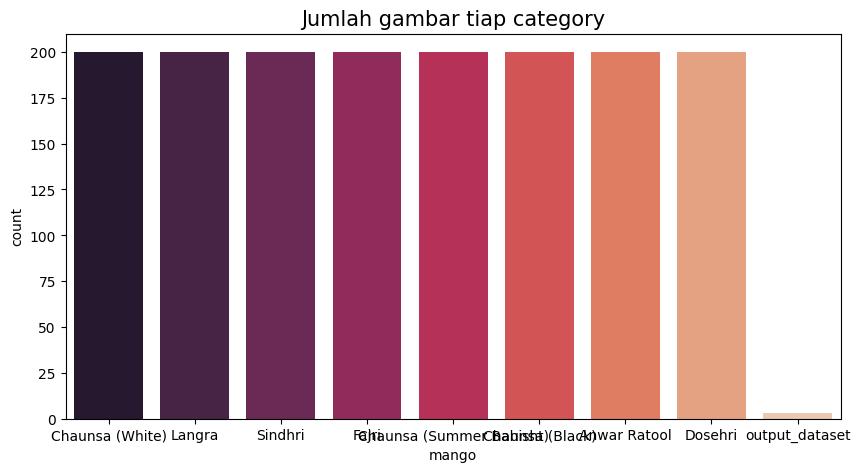

In [6]:
# menampilkan jumlah gambar pada tiap category
vc = df["mango"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Jumlah gambar tiap category", fontsize = 15)
plt.show()

In [7]:
# ## install library untuk pembagian dataset menjadi 3 yaitu train,test,val
# !pip install split_folders
# ## install library untuk pembagian dataset menjadi 3 yaitu train,test,val
# import splitfolders

In [8]:
# # pembagian dataset menjadi 3 yaitu train,test,val
# input_folders = '/content/drive/MyDrive/mango/Classification_dataset'
# output_folders = '/content/drive/MyDrive/mango/Classification_dataset/output_dataset'
# splitfolders.ratio(input_folders,output_folders, seed =42, ratio=(.7,.2,.1))

In [9]:

# Importing Required Libraries
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model


Arsitektur Vgg16

In [10]:
from keras.applications.vgg16 import VGG16

In [11]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224,224,3),
)

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
# Mengunci semua layer base_model agar tidak terupdate selama pelatihan
for layer in base_model.layers:
    layer.trainable = False

# Membuat output layer kustom untuk jumlah kelas yang diinginkan
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(8, activation='softmax')(x)

# Menggabungkan base model dengan output layer kustom
model = Model(inputs=base_model.input, outputs=x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Preprcessing

In [14]:
# path data train dan data validation
val_path ='/content/drive/MyDrive/mango/Classification_dataset/output_dataset/val'
training_path ='/content/drive/MyDrive/mango/Classification_dataset/output_dataset/train'

# path data testing
testing_path ='/content/drive/MyDrive/mango/Classification_dataset/output_dataset/test'

In [15]:
train_datagen = ImageDataGenerator (rescale = 1./255,
                                    zoom_range = 0.2,
                                    rotation_range = 20)

valid_datagen = ImageDataGenerator(rescale = 1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)

Hyperparameter

In [16]:
# Compile the Model
model.compile( loss='sparse_categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [17]:
 #Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/mango/Classification_dataset/output_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'sparse')

Found 1120 images belonging to 9 classes.


In [18]:
valid_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/mango/Classification_dataset/output_dataset/val',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'sparse')

Found 320 images belonging to 9 classes.


In [19]:
testing_set = testing_datagen.flow_from_directory('/content/drive/MyDrive/mango/Classification_dataset/output_dataset/test',
                                                target_size=(224,224),
                                                batch_size=16,
                                                class_mode='sparse', shuffle=False)

Found 160 images belonging to 9 classes.


Training dengan Arsitektur VGG16

In [21]:
# Fit the model
r = model.fit(
              training_set,
              validation_data=valid_set,
              epochs=60,
              steps_per_epoch=len(training_set),
              validation_steps=len(valid_set))

Epoch 1/60
70/70 [==============================] - 414s 6s/step - loss: 0.9707 - accuracy: 0.6661 - val_loss: 0.5243 - val_accuracy: 0.8062
Epoch 2/60
70/70 [==============================] - 25s 353ms/step - loss: 0.5273 - accuracy: 0.8313 - val_loss: 0.3254 - val_accuracy: 0.9000
Epoch 3/60
70/70 [==============================] - 25s 355ms/step - loss: 0.4196 - accuracy: 0.8652 - val_loss: 0.3645 - val_accuracy: 0.8969
Epoch 4/60
70/70 [==============================] - 23s 334ms/step - loss: 0.2603 - accuracy: 0.9196 - val_loss: 0.1782 - val_accuracy: 0.9594
Epoch 5/60
70/70 [==============================] - 25s 347ms/step - loss: 0.1661 - accuracy: 0.9554 - val_loss: 0.1410 - val_accuracy: 0.9750
Epoch 6/60
70/70 [==============================] - 25s 349ms/step - loss: 0.1604 - accuracy: 0.9598 - val_loss: 0.1491 - val_accuracy: 0.9594
Epoch 7/60
70/70 [==============================] - 27s 382ms/step - loss: 0.1763 - accuracy: 0.9491 - val_loss: 0.0902 - val_accuracy: 0.9812
E

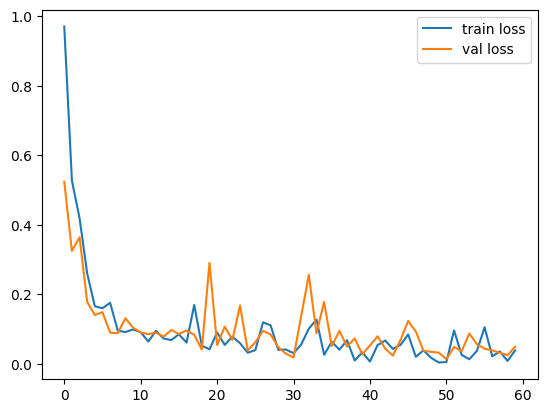

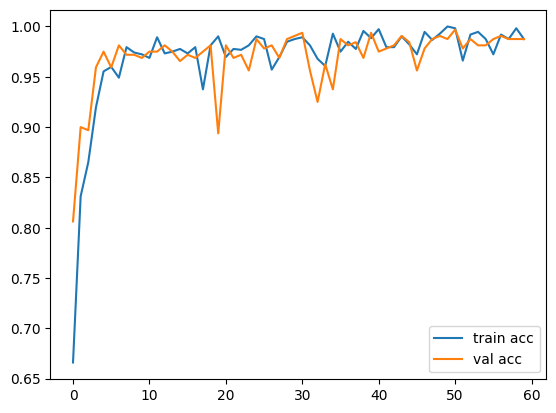

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [23]:
scores_validasi = model.evaluate(valid_set)

20/20 [==============================] - 2s 114ms/step - loss: 0.0495 - accuracy: 0.9875


In [24]:
scores_train = model.evaluate(training_set)

70/70 [==============================] - 21s 296ms/step - loss: 0.0134 - accuracy: 0.9955


In [ ]:
#save model
model.save("/content/drive/MyDrive/Model/P5_adam_0.001_E_60.h5")

In [26]:
model.save("/content/drive/MyDrive/Model/P5_adam_0.001_E_60.hdf5")